# Notebook to run orbits of clusters and streams

You can read more about astropy units here:
https://docs.astropy.org/en/stable/units/index.html

You can read more about the gala pacakge which is used throughout this notebook for orbit integration, potentials etc here:
http://gala.adrian.pw/en/latest/

In [1]:
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic
import astropy.constants as const
from gala.potential import BovyMWPotential2014


import galstreams

        Use @ instead. [gala.coordinates.sgr]
        Use @ instead. [gala.coordinates.orphan]
        Use @ instead. [gala.coordinates.magellanic_stream]


A new version of galpy (1.9.2) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


In [2]:
mpl.rcParams.update({'font.size': 24})
label_size = 24
mpl.rcParams['xtick.labelsize'] = 22 #label_size 
mpl.rcParams['ytick.labelsize'] = 22 #label_size 

## Set up the potential models:

Load the new Gala Milky Way model:

In [3]:
# you'll need to change this path to the folder where you store the file I sent 
# I will send you this file
# this potential includes a dark matter halo, disk, and bulge + nucleus for the MW
mw = gp.load('MilkyWayPotential2022.yml')

#mw = BovyMWPotential2014()

In [5]:
xyz = np.zeros((3, 1024))
xyz[0] = np.linspace(0, 25, xyz.shape[1])

In [19]:
def stream_mass_from_width(r,width):
    """
    computes stream mass estimate given its width
    params: r, stream galactocentric distance (kpc)
            width, stream width (pc)
    returns: stream width estimate in solar masses
    """
    w = width/(r*1000)
    xyz = np.zeros((3, 1024))
    xyz[0] = [r]
    mprof = mw.mass_enclosed(xyz)
    M_r = mprof[0]
    mass_estimate = 2**(1/2)*3**(3/2)*M_r*w**3
    return mass_estimate

In [13]:
stream_mass_from_width(r=18.9,width=53)

<Quantity 32244.9860542 solMass>

(0.0, 250.0)

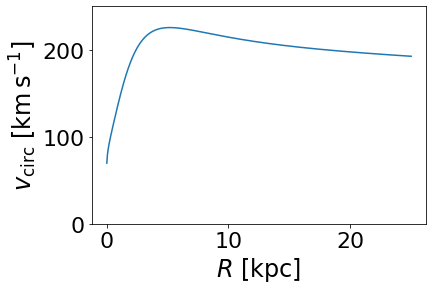

In [12]:
# plot the circular velocity of the potential with galactocentric radius
for pot in [mw]:
    vcirc = pot.circular_velocity(xyz)
    plt.plot(xyz[0], vcirc)
plt.xlabel('$R$ [kpc]')
plt.ylabel(r'$v_{\rm circ}$ ' + f'[{vcirc.unit:latex_inline}]')
plt.ylim(0, 250)

Plot the density at the midplane of the  potential model:

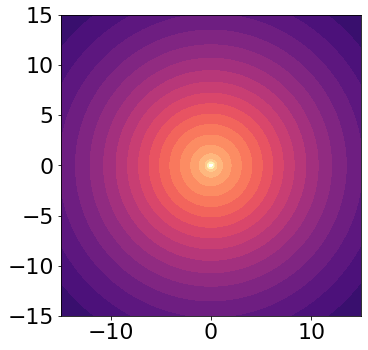

In [6]:
grid = (np.linspace(-15, 15, 128), np.linspace(-15, 15, 128), 0)
levels = np.geomspace(1e6, 1e10, 24)

fig, axes = plt.subplots(
    1, 1, 
    figsize=(5, 5), 
    sharex=True, sharey=True,
    constrained_layout=True
)
for pot in [mw]:
    pot.plot_density_contours(
    grid=grid, ax=axes, 
    levels=levels, cmap='magma', 
    norm=mpl.colors.LogNorm(vmin=levels.min(), vmax=levels.max()))
    axes.set_aspect('equal')

## Set up hamiltonian 

In [6]:

test_frame = gp.StaticFrame(galactic)

H = gp.Hamiltonian(mw, test_frame)


In [47]:
for i,name in enumerate(df["# Name"]):
    if name == "NGC_3201":
        print(i)

18


## Transform from 6d phase space sky coords to galactic coords

To integrate the orbits of streams and clusters you need their 6D phase space coordinates (ra,dec,distance,proper motion1,proper motion2, radial velocity) in galactic coordinates in your potential (x,y,z,vx,vy,vz)

See more info here  https://docs.astropy.org/en/stable/generated/examples/coordinates/plot_galactocentric-frame.html

In [4]:
df = pd.read_fwf("input.txt")

In [5]:
class GC:
    
    def __init__(self,name):
        self.name = name
        
        index = df.loc[df['# Name'] == name].index[0]
        
        
        self.ra = df['ra'][index]*u.degree
        self.dec = df['dec'][index]*u.degree
        self.pm_ra = df['pmra'][index]*u.mas/u.yr
        self.pm_dec = df['pmdec'][index]*u.mas/u.yr
        self.vlos = df['vlos'][index]*u.km/u.s
        self.dist = df['dist'][index]*u.kpc
        
        self.coords = coord.SkyCoord(ra=self.ra, dec=self.dec,
                        distance=self.dist,
                        pm_ra_cosdec=self.pm_ra,
                        pm_dec=self.pm_dec,
                        radial_velocity=self.vlos,
                        frame='icrs')
        
        
        
        
    def integrate_orbit(self,time,dt,verbose=False):
            
        c1 = self.coords
        gc1 = c1.transform_to(coord.Galactocentric)
        
        
        glob_w0 = gd.PhaseSpacePosition(
        [gc1.x.value,  gc1.y.value,  gc1.z.value] * u.kpc ,
        [gc1.v_x.value,  gc1.v_y.value,  gc1.v_z.value]*u.km/u.s
        
        )
    
        test_frame = gp.StaticFrame(galactic)

        H = gp.Hamiltonian(mw, test_frame)
    
        prog_orbit = H.integrate_orbit(
        glob_w0, 
        dt=dt, t1=0, t2=time, 
        Integrator=gi.DOPRI853Integrator
        ).to_frame(test_frame)



        prog_orbit = H.integrate_orbit(
        glob_w0, 
        t=prog_orbit.t,
        Integrator=gi.DOPRI853Integrator
        )
        
        self.orbit = prog_orbit
        
        if verbose:
            fig = prog_orbit.plot();
            fig.suptitle('Orbit in Milky Way-like potential', fontsize=24)
            
        
        
    def num_crossings(self,limit=None):
            
            
        x_vals = self.orbit.pos.x.value
        y_vals = self.orbit.pos.y.value
        z_vals = self.orbit.pos.z.value
            
        num_crossings = 0
    
        if limit is not None:
        
            for i in range(len(z_vals) - 1):
                if np.sign(z_vals[i]) + np.sign(z_vals[i+1]) == 0 and np.mean([(x_vals[i]**2 + y_vals[i]**2)**0.5,(x_vals[i+1]**2 + y_vals[i+1]**2)**0.5]) < limit.value:
                    num_crossings += 1
    
        else:
        
            for i in range(len(z_vals) - 1):
                if np.sign(z_vals[i]) + np.sign(z_vals[i+1]) == 0:
                    num_crossings +=1
            
        return num_crossings
    
    
    
    def crossing_radius(self):
        x_vals = self.orbit.pos.x.value
        y_vals = self.orbit.pos.y.value
        z_vals = self.orbit.pos.z.value
        
        
        num_crossings = 0
        crossing_radii = []
    
        for i in range(len(z_vals) - 1):
            if np.sign(z_vals[i]) + np.sign(z_vals[i+1]) == 0:
                num_crossings +=1
                crossing_radius = np.mean([(x_vals[i]**2 + y_vals[i]**2)**0.5,(x_vals[i+1]**2 + y_vals[i+1]**2)**0.5])
                crossing_radii.append(crossing_radius)
            
        crossings = np.array(crossing_radii)
    
        if num_crossings > 0:
            avg_crossing = np.sum(crossings)/num_crossings
            return avg_crossing
    
        else:
            return 0
        
    

## attributes: 6D, name

##methods:

##integrate orbit: integrates the orbit. Creates new attributes from orbit




## class ST




In [5]:
#pal5 = GC("Pal_5")
#pal5.integrate_orbit(time=200*u.Myr,dt=.001)


x = -6004.01106
y = 8646.8784
z = 0.0

vx = -184.37471
vy = -127.15512
vz = 0.0


w0 = gd.PhaseSpacePosition(pos=[x,y,z]*u.pc,vel = [vx,vy,vz]*(u.pc/u.Myr))
gmc_orbit = mw.integrate_orbit(w0, dt=.001*u.Myr, t1=0*u.Myr, t2=200*u.Myr)


x = 7197.0586
y = 223.6452
z = 15725.603

vx = -45.683761
vy = -149.92448
vz = -11.32242

w0 = gd.PhaseSpacePosition(pos=[x,y,z]*u.pc,vel = [vx,vy,vz]*(u.km/u.s))
pal5_orbit = mw.integrate_orbit(w0, dt=.001*u.Myr, t1=0*u.Myr, t2=200*u.Myr)

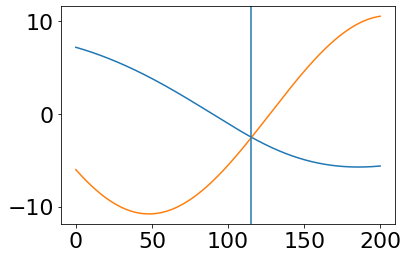

In [46]:
plt.plot(pal5_orbit.t,pal5_orbit.x)
plt.plot(gmc_orbit.t,gmc_orbit.x)
plt.axvline(115)

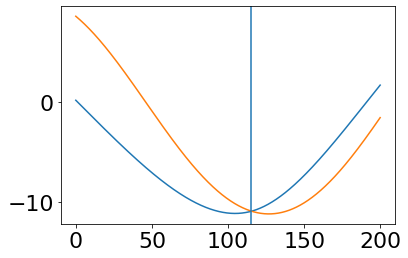

In [47]:
plt.plot(pal5_orbit.t,pal5_orbit.y)
plt.plot(gmc_orbit.t,gmc_orbit.y)
plt.axvline(115)

[Text(0.5, 0.92, 'Gala')]

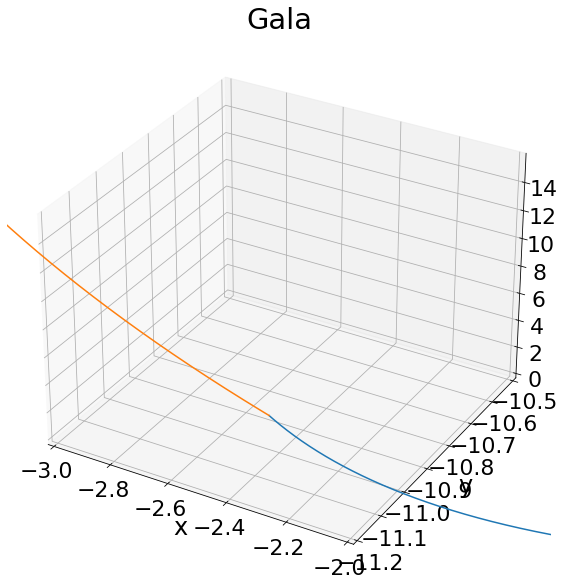

In [18]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.plot(pal5_orbit.x[:115479],pal5_orbit.y[:115479],pal5_orbit.z[:115479])
ax.plot(gmc_orbit.x[:115479],gmc_orbit.y[:115479],gmc_orbit.z[:115479])
ax.set(xlabel="x",ylabel="y",xlim=(-3,-2),ylim=(-11.2,-10.5))
ax.set(title="Gala")

In [16]:
(pal5.orbit.x[115479] + pal5.orbit.x[115480])/2

<Quantity -2.51872453 kpc>

In [15]:
pal5.orbit.z[115480].to(u.pc)

<Quantity -0.06760914 pc>

In [62]:
pal5.orbit.t[1154797]

<Quantity 115.4797 Myr>

In [74]:
v = (pal5.orbit.v_x[1154797]**2 + pal5.orbit.v_y[1154797]**2 + pal5.orbit.v_z[1154797]**2)**0.5
vz = pal5.orbit.v_z[1154797]

In [109]:
((pal5.orbit.v_x[1154797]**2 + pal5.orbit.v_y[1154797]**2)**0.5/-np.tan(np.radians(60))).to(u.pc/u.Myr)

<Quantity -57.6710797 pc / Myr>

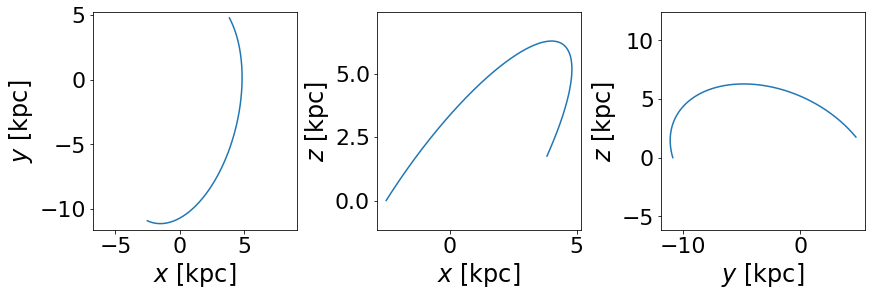

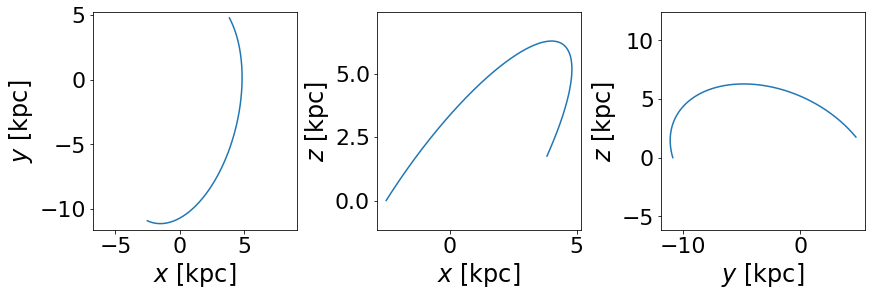

In [114]:
x = pal5.orbit.x[1154797]
y = pal5.orbit.y[1154797]
z = pal5.orbit.z[1154797]

vx = pal5.orbit.v_x[1154797]
vy = pal5.orbit.v_y[1154797]
vz = ((pal5.orbit.v_x[1154797]**2 + pal5.orbit.v_y[1154797]**2)**0.5/-np.tan(np.radians(35)))


w0 = gd.PhaseSpacePosition(pos=[x,y,z]*u.kpc,vel = [vx,vy,vz]*(u.kpc/u.Myr))
orbit = mw.integrate_orbit(w0, dt=-0.0001*u.Myr, t1=115.4798*u.Myr, t2=0*u.Myr)
orbit.plot(['x','y','z'])

In [127]:
orbit.z[-1].to(u.pc)

<Quantity 1750.25752154 pc>

In [101]:
orbit.t[-1]

<Quantity 0. Myr>

In [80]:
(pal5.orbit.x[6862] + pal5.orbit.x[6863])/2

<Quantity -2.33733682 kpc>

In [63]:
0.0044983099795944*8.4e5

3778.580382859296

In [15]:
z_vals = pal5.orbit.z.value
for i in range(len(z_vals) - 1):
    if np.sign(z_vals[i]) + np.sign(z_vals[i+1]) == 0:
        print(i)

107
323
476
703
934


In [26]:
crossings = []

for name in df["# Name"]:
    glob = GC(name)
    try:
        glob.integrate_orbit(time=1*u.Gyr)
        crossings.append(glob.num_crossings(limit=8500*u.kpc))
    except RuntimeError:
        pass
    
#crossings = [num for num in crossings if num > 0]   

In [20]:
np.sum(np.array(crossings))*.05136/161

1.2469952795031056

In [31]:
sigma

<Quantity 0.07059516>

In [30]:
R = 51*u.pc


mcs = 500*np.pi*(R + 50*u.pc)**2
area = np.pi*(8500*u.pc)**2

sigma = mcs/area

print(np.sum(np.array(crossings))*sigma/161)

1.7640019342775473


In [6]:

def integrate_orbit(name,verbose=False,return_vals=False):

    index = df.loc[df['# Name'] == name].index[0]

    ra = df['ra'][index]*u.degree
    dec = df['dec'][index]*u.degree
    pm_ra = df['pmra'][index]*u.mas/u.yr
    pm_dec = df['pmdec'][index]*u.mas/u.yr
    vlos = df['vlos'][index]*u.km/u.s
    dist = df['dist'][index]*u.kpc


    c1 = coord.SkyCoord(ra=ra, dec=dec,
                        distance=dist,
                        pm_ra_cosdec=pm_ra,
                        pm_dec=pm_dec,
                        radial_velocity=vlos,
                        frame='icrs')

    gc1 = c1.transform_to(coord.Galactocentric)


    glob_w0 = gd.PhaseSpacePosition(
        [gc1.x.value,  gc1.y.value,  gc1.z.value] * u.kpc ,
        [gc1.v_x.value,  gc1.v_y.value,  gc1.v_z.value]*u.km/u.s
    )
    
    test_frame = gp.StaticFrame(galactic)

    H = gp.Hamiltonian(mw, test_frame)
    
    prog_orbit = H.integrate_orbit(
    glob_w0, 
    dt=1, t1=0, t2=5*u.Gyr, 
    Integrator=gi.DOPRI853Integrator
    ).to_frame(test_frame)



    prog_orbit = H.integrate_orbit(
        glob_w0, 
        t=prog_orbit.t,
        Integrator=gi.DOPRI853Integrator
    )

    #print('orbit pericenter and apocenter')
    #here you can easily compute the orbital parameters such as apocenter/pericenter 
    #print(prog_orbit.pericenter(), prog_orbit.apocenter())
    if verbose:
        fig = prog_orbit.plot();
        fig.suptitle('Orbit in Milky Way-like potential', fontsize=24)
        
    if return_vals:
        return prog_orbit.pericenter().value, prog_orbit.apocenter().value, np.median(prog_orbit.energy()).value, np.median(prog_orbit.angular_momentum()[-1]).value
    
    
    
def num_crossings(name,time,limit=None):
    """
    computes number of crossing (z=0) for a given orbital integration time
    params: 
    time: time specified with astropy units
    name: name of 
    limit: only consider crossings up to a certain galactocentric radius.
    """
    index = df.loc[df['# Name'] == name].index[0]

    ra = df['ra'][index]*u.degree
    dec = df['dec'][index]*u.degree
    pm_ra = df['pmra'][index]*u.mas/u.yr
    pm_dec = df['pmdec'][index]*u.mas/u.yr
    vlos = df['vlos'][index]*u.km/u.s
    dist = df['dist'][index]*u.kpc


    c1 = coord.SkyCoord(ra=ra, dec=dec,
                        distance=dist,
                        pm_ra_cosdec=pm_ra,
                        pm_dec=pm_dec,
                        radial_velocity=vlos,
                        frame='icrs')

    gc1 = c1.transform_to(coord.Galactocentric)


    glob_w0 = gd.PhaseSpacePosition(
        [gc1.x.value,  gc1.y.value,  gc1.z.value] * u.kpc ,
        [gc1.v_x.value,  gc1.v_y.value,  gc1.v_z.value]*u.km/u.s
    )
    
    test_frame = gp.StaticFrame(galactic)

    H = gp.Hamiltonian(mw, test_frame)
    
    prog_orbit = H.integrate_orbit(
    glob_w0, 
    dt=1, t1=0, t2=time, 
    Integrator=gi.DOPRI853Integrator
    ).to_frame(test_frame)



    prog_orbit = H.integrate_orbit(
        glob_w0, 
        t=prog_orbit.t,
        Integrator=gi.DOPRI853Integrator
    )
    
    
    x_vals = prog_orbit.pos.x.value
    y_vals = prog_orbit.pos.y.value
    z_vals = prog_orbit.pos.z.value
    
    
    num_crossings = 0
    
          
        
    if limit is not None:
        
        for i in range(len(z_vals) - 1):
            if np.sign(z_vals[i]) + np.sign(z_vals[i+1]) == 0 and np.mean([(x_vals[i]**2 + y_vals[i]**2)**0.5,(x_vals[i+1]**2 + y_vals[i+1]**2)**0.5]) < limit.value:
                num_crossings += 1
    
    else:
        
        for i in range(len(z_vals) - 1):
            if np.sign(z_vals[i]) + np.sign(z_vals[i+1]) == 0:
                num_crossings +=1
            
                  
            
    return num_crossings




def crossing_radius(name,time):
    """
    computes the average crossing radius per unit time for a cluster
    params:
        name: cluster name
        time: time to integrate for
    """
    
    index = df.loc[df['# Name'] == name].index[0]

    ra = df['ra'][index]*u.degree
    dec = df['dec'][index]*u.degree
    pm_ra = df['pmra'][index]*u.mas/u.yr
    pm_dec = df['pmdec'][index]*u.mas/u.yr
    vlos = df['vlos'][index]*u.km/u.s
    dist = df['dist'][index]*u.kpc


    c1 = coord.SkyCoord(ra=ra, dec=dec,
                        distance=dist,
                        pm_ra_cosdec=pm_ra,
                        pm_dec=pm_dec,
                        radial_velocity=vlos,
                        frame='icrs')

    gc1 = c1.transform_to(coord.Galactocentric)


    glob_w0 = gd.PhaseSpacePosition(
        [gc1.x.value,  gc1.y.value,  gc1.z.value] * u.kpc ,
        [gc1.v_x.value,  gc1.v_y.value,  gc1.v_z.value]*u.km/u.s
    )
    
    test_frame = gp.StaticFrame(galactic)

    H = gp.Hamiltonian(mw, test_frame)
    
    prog_orbit = H.integrate_orbit(
    glob_w0, 
    dt=1, t1=0, t2=time, 
    Integrator=gi.DOPRI853Integrator
    ).to_frame(test_frame)



    prog_orbit = H.integrate_orbit(
        glob_w0, 
        t=prog_orbit.t,
        Integrator=gi.DOPRI853Integrator
    )
    
    
    x_vals = prog_orbit.pos.x.value
    y_vals = prog_orbit.pos.y.value
    z_vals = prog_orbit.pos.z.value
    
    
    num_crossings = 0
    crossing_radii = []
    
    for i in range(len(z_vals) - 1):
        if np.sign(z_vals[i]) + np.sign(z_vals[i+1]) == 0:
            num_crossings +=1
            crossing_radius = np.mean([(x_vals[i]**2 + y_vals[i]**2)**0.5,(x_vals[i+1]**2 + y_vals[i+1]**2)**0.5])
            crossing_radii.append(crossing_radius)
            
    crossings = np.array(crossing_radii)
    
    if num_crossings > 0:
        avg_crossing = np.sum(crossings)/num_crossings
        return avg_crossing
    
    else:
        return 0
                
                
        
                
    

## Number of Clusters as a function of crossing radius:

In [10]:
crossing_dist = []
for name in df["# Name"]:
    
    try:
        cross_dist = crossing_radius(name,1*u.Gyr)
        crossing_dist.append(cross_dist)
    except RuntimeError:
        pass
    
crossing_dist.remove(0)
crossing_dist.remove(0)

In [23]:
crossing_dist

[6.718099661856948,
 5.713037786327876,
 3.3754266520002494,
 34.67031500695599,
 3.9981066195530772,
 18.59969007637993,
 5.304522393829129,
 64.49222668424896,
 4.503946710145085,
 5.93684533794847,
 5.165234768239657,
 5.857298351346162,
 40.85176386113163,
 81.8253460568576,
 5.8520928634314675,
 11.390002074632287,
 79.45158586019897,
 25.93023075054893,
 13.440365794670413,
 1.2490742130545436,
 4.849029676100888,
 6.690262741505751,
 13.50177488727299,
 5.6632132563441715,
 3.910320763221089,
 14.098395079674416,
 14.549402832144512,
 3.909910670791819,
 9.221829532403545,
 4.880634065998434,
 27.422837226819844,
 0,
 6.616401104118041,
 39.63267525597919,
 10.017417746571816,
 43.97706205486812,
 26.8720166856592,
 13.300266291511758,
 4.994973792439913,
 3.862519964116879,
 4.899605487318332,
 2.674002619286635,
 16.12388321342264,
 2.506842879700039,
 3.5885002725599877,
 0,
 3.0285824434098254,
 1.9984575101615563,
 3.5176073256667384,
 29.031447963738984,
 2.349124638364744

In [35]:
truth_table = np.array(crossing_dist) < 8.5
count = 0
for value in truth_table:
    if value:
        count +=1
        
count/161

0.782608695652174

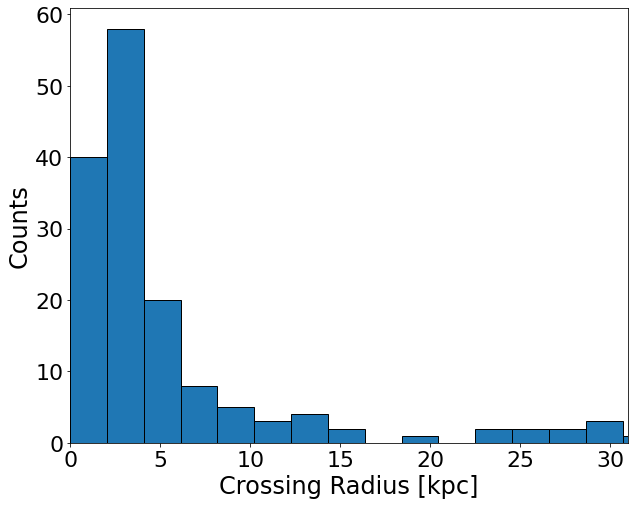

In [27]:
fig, ax = plt.subplots(1,1,figsize=(10,8))


#ax[0].hist(crossing_dist,edgecolor='black')
ax.hist(crossing_dist,bins=40,edgecolor='black')


#ax[0].set(xlabel="Crossing Radius [kpc]",ylabel="Counts")
ax.set(xlabel="Crossing Radius [kpc]",ylabel="Number of Globular Clusters",xlim=(0,31))
plt.show()

## Average Number of crossings per Gyr:

In [7]:
num_crosses = []
for name in df["# Name"]:
    
    try:
        num_cross = num_crossings(name,1*u.Gyr)
        num_crosses.append(num_cross)
    except RuntimeError:
        pass

In [122]:
np.mean(num_crosses)

24.987577639751553

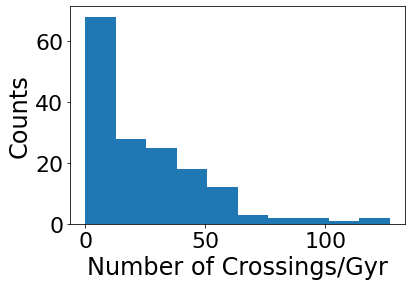

In [140]:
plt.hist(num_crosses)
plt.xlabel("Number of Crossings/Gyr")
plt.ylabel("Counts")
plt.show()

In [118]:
num_crosses_limited = []
for name in df["# Name"]:
    
    try:
        num_cross = num_crossings(name,1*u.Gyr,limit=10*u.kpc)
        num_crosses_limited.append(num_cross)
    except RuntimeError:
        pass

In [146]:
len(np.where(np.array(num_crosses_limited) > 0)[0])

137

In [123]:
np.mean(num_crosses_limited)

24.279503105590063

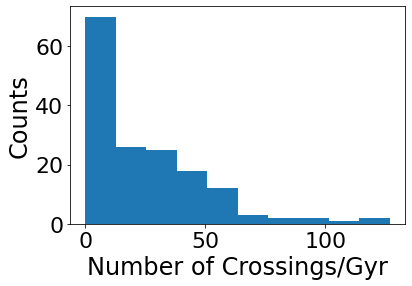

In [128]:
plt.hist(num_crosses_limited)
plt.xlabel("Number of Crossings/Gyr")
plt.ylabel("Counts")
plt.show()

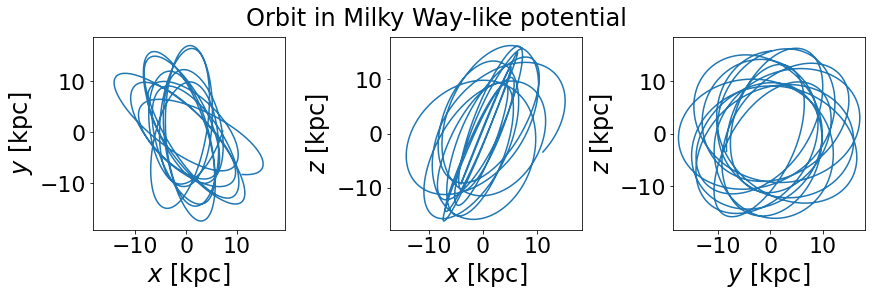

In [6]:
integrate_orbit(name='Pal_5',return_vals=False,verbose=True)

In [7]:
%%time
apocenters = np.zeros(len(df["# Name"]))
pericenters = np.zeros(len(df['# Name']))
energies = np.zeros(len(df["# Name"]))
lz = np.zeros(len(df["# Name"]))


for i,name in enumerate(df["# Name"]):
    try:
        pericenters[i] = integrate_orbit(name=name,return_vals=True)[0]
        apocenters[i] = integrate_orbit(name=name,return_vals=True)[1]
        energies[i] = integrate_orbit(name=name,return_vals=True)[2]
        lz[i] = integrate_orbit(name=name,return_vals=True)[3]
        
    except RuntimeError:
        pericenters[i] = float('nan')
        apocenters[i] = float('nan')

df['apocenter'] = apocenters
df['pericenter'] = pericenters

CPU times: user 1min 6s, sys: 947 ms, total: 1min 7s
Wall time: 1min 7s


In [8]:
delta = np.array(df["rmax"])
dists = np.array(df["dist"])
sigma = np.array(df["sigma"])

radii = dists*delta*60/206_265 ## units are kpc

radii = radii*u.kpc
sigma = sigma*u.km/u.s
alpha = 1

mass_estimate = alpha*radii.to(u.m)*sigma.to(u.m/u.s)**2/const.G
mass_estimate = mass_estimate.to(u.M_sun)

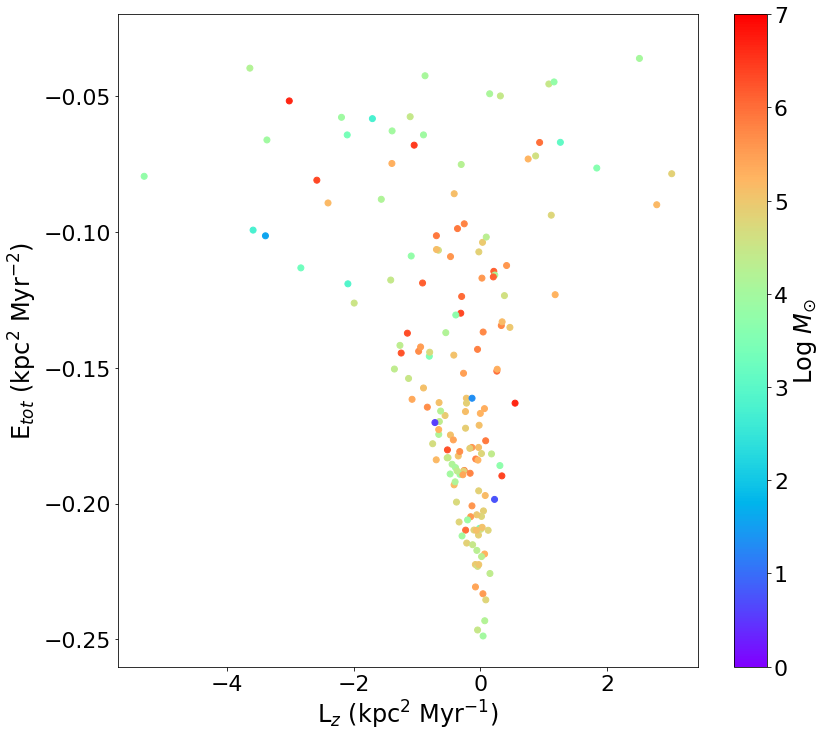

In [14]:
mass_logs = np.round(np.log10(mass_estimate.value),2)

cmap = plt.cm.rainbow
norm = mpl.colors.Normalize(vmin=0,vmax=7)


plt.figure(figsize=(13,12))
plt.scatter(lz,energies,c=mass_logs,norm=norm,cmap=cmap)
plt.ylim(-0.26,-0.02)
plt.colorbar(label="Log $M_{\odot}$")
plt.xlabel("L$_z$ (kpc$^2$ Myr$^{-1}$)")
plt.ylabel("E$_{tot}$ (kpc$^2$ Myr$^{-2}$)")
plt.show()

In [7]:
# example of cluster 6D sky coordinates
# below I use the Pal 5 GC coordinates from Vasiliev et al. 2021

c1 = coord.SkyCoord(ra=229.019*u.degree, dec=-0.121*u.degree,
                    distance=20.6*u.kpc,
                    pm_ra_cosdec=-2.730 *u.mas/u.yr,
                    pm_dec=-2.654 *u.mas/u.yr,
                    radial_velocity=-56.2 *u.km/u.s,
                    frame='icrs')

In [15]:
gc1 = c1.transform_to(coord.Galactocentric)


glob_w0 = gd.PhaseSpacePosition(
        [gc1.x.value,  gc1.y.value,  gc1.z.value] * u.kpc ,
        [gc1.v_x.value,  gc1.v_y.value,  gc1.v_z.value]*u.km/u.s
)
    
test_frame = gp.StaticFrame(galactic)

H = gp.Hamiltonian(mw, test_frame)
    
prog_orbit = H.integrate_orbit(
    glob_w0, 
    dt=1, t1=0, t2=5*u.Gyr, 
    Integrator=gi.DOPRI853Integrator
    ).to_frame(test_frame)



prog_orbit = H.integrate_orbit(
        glob_w0, 
        t=prog_orbit.t,
        Integrator=gi.DOPRI853Integrator
    )

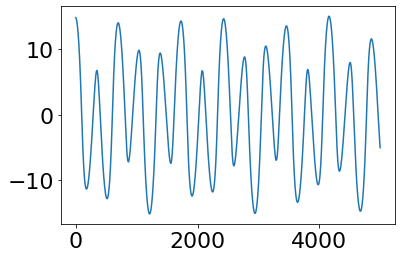

In [124]:
z_vals = prog_orbit.pos.z.value
t = np.arange(0,5000)

plt.plot(t,z_vals)
plt.show()

In [68]:
num_crossings = 0
for i in range(len(z_vals) - 1):
    if np.sign(z_vals[i]) + np.sign(z_vals[i+1]) == 0:
        num_crossings += 1
        
print(num_crossings)

29


## Get Lz and Etot for streams with 6D Phase Space info:

In [15]:
mws = galstreams.MWStreams(verbose=False, implement_Off=False, print_topcat_friendly_files=False)

Initializing galstreams library from master_log... 


        Use @ instead. [gala.coordinates.greatcircle]


In [8]:
mws.get_track_names_for_stream("Fimbulthul",On_only=True)

['OmegaCen-I21']

In [12]:
mws.summary.loc["OmegaCen-I21"]

Imp                                          st
On                                         True
TrackName                          OmegaCen-I21
Name                        OmegaCen-Fimbulthul
TrackRefs                             ibata2021
TrackRefsLatex                        Ibata2021
Notes                                         -
length                                 43.37243
ra_o                                 198.652558
dec_o                                -52.905069
distance_o                             5.104994
ra_f                                 213.220732
dec_f                                 -19.25222
distance_f                              2.92917
ra_mid                                195.79789
dec_mid                              -30.846169
distance_mid                           5.299425
ra_pole                               124.24158
dec_pole                              27.917444
InfoFlags                                  1110
has_empirical_track                     

In [11]:
for st in mws.all_track_names():
    if mws.summary.loc[st]["InfoFlags"] == "1111":
        print (st)

AAU-AliqaUma-L21
AAU-ATLAS-L21
Aquarius-W11
LMS1-Y20
Orphan-K19


In [16]:
tracks = ["AAU-AliqaUma-L21","Pal5-PW19","GD-1-I21","AAU-ATLAS-L21","Aquarius-W11","LMS1-Y20","Orphan-K19",]
stream_mass = np.array([18e4,2e4,1e5,12e4,1e-5,1e-5,1e-5,])
stream_energy = []
stream_momenta = []

for st in tracks:
    ra = np.median(mws[st].track.to_table()["ra"].value)*u.degree
    dec = np.median(mws[st].track.to_table()["dec"].value)*u.degree
    pmra = np.median(mws[st].track.to_table()["pm_ra_cosdec"].value)*u.mas/u.yr
    pmdec = np.median(mws[st].track.to_table()["pm_dec"].value)*u.mas/u.yr
    dist = np.median(mws[st].track.to_table()["distance"].value)*u.kpc
    if st == "Pal5-PW19":
        vrad = -56.2*u.km/u.s
    elif st == "GD-1-I21":
        vrad = -50*u.km/u.s
    
    else:
        vrad = np.median(mws[st].track.to_table()["radial_velocity"].value)*u.km/u.s
    
    
    
    c1 = coord.SkyCoord(ra=ra, dec=dec,
                        distance=dist,
                        pm_ra_cosdec=pmra,
                        pm_dec=pmdec,
                        radial_velocity=vrad,
                        frame='icrs')

    gc1 = c1.transform_to(coord.Galactocentric)


    glob_w0 = gd.PhaseSpacePosition(
        [gc1.x.value,  gc1.y.value,  gc1.z.value] * u.kpc ,
        [gc1.v_x.value,  gc1.v_y.value,  gc1.v_z.value]*u.km/u.s
    )
    
    test_frame = gp.StaticFrame(galactic)

    H = gp.Hamiltonian(mw, test_frame)
    
    prog_orbit = H.integrate_orbit(
    glob_w0, 
    dt=1, t1=0, t2=5*u.Gyr, 
    Integrator=gi.DOPRI853Integrator
    ).to_frame(test_frame)



    prog_orbit = H.integrate_orbit(
        glob_w0, 
        t=prog_orbit.t,
        Integrator=gi.DOPRI853Integrator
    )
    
    
    stream_energy.append(np.median(prog_orbit.energy()).value)
    stream_momenta.append(np.median(prog_orbit.angular_momentum()[-1]).value)

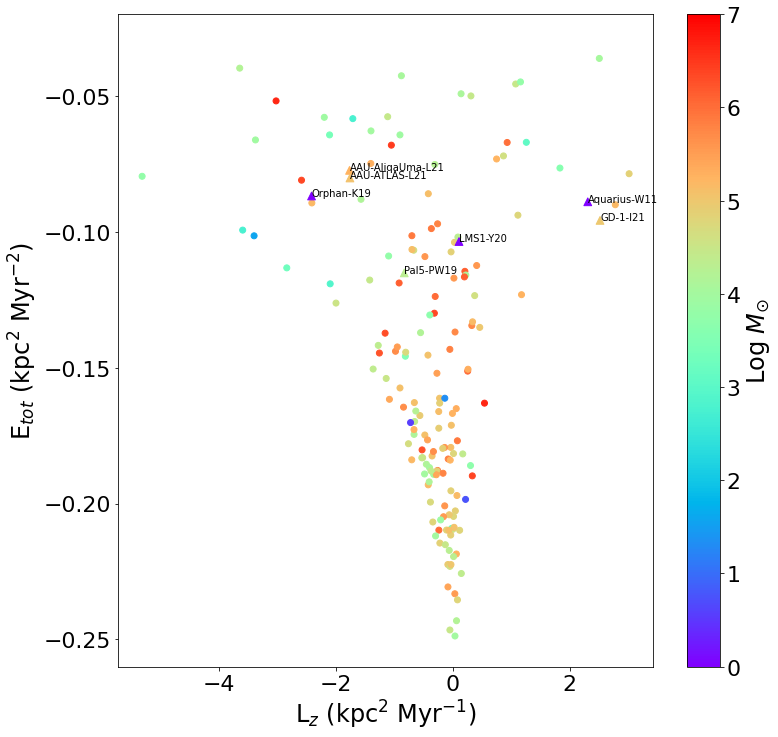

In [17]:
stream_mlogs = np.log10(stream_mass)
cmap = plt.cm.rainbow
norm = mpl.colors.Normalize(vmin=0,vmax=7)

fig = plt.figure(figsize=(12,12))
ax1 = plt.subplot()
ax2 = plt.subplot()

img = ax1.scatter(lz,energies,c=mass_logs,norm=norm,cmap=cmap)
ax2.scatter(stream_momenta,stream_energy,c=stream_mlogs,cmap=cmap,norm=norm,marker='^',s=60,label=tracks)
plt.ylim(-0.26,-0.02)
fig.colorbar(img,ax=ax1,label="Log $M_{\odot}$")
plt.xlabel("L$_z$ (kpc$^2$ Myr$^{-1}$)")
plt.ylabel("E$_{tot}$ (kpc$^2$ Myr$^{-2}$)")

for i, label in enumerate(tracks):
    ax2.annotate(label,(stream_momenta[i],stream_energy[i]),fontsize=10)
    
#ax2.axvline(2.78)
#ax2.axhline(-0.09)
plt.show()

In [20]:
##Aditional Stream info from Ting Li et. al 2022:

ting_st = ["300S","Ophiucus","Wilka Yaku","Jet","Phoenix","Orphan",
           "Chenab","Jhelum","Indus","Palca","Elqui","Turranburra"]

ting_w = np.array([110,8,127,90,53,747,493,267,240,1000,472,288])
ting_e = np.array([-0.10,-0.16,-0.10,-0.10,-0.13,-0.10,-0.09,-0.12,-0.13,-0.10,-0.09,-0.11])
ting_l = np.array([0.44,-0.15,-2.93,1.65,-1.66,-4,-3.41,-0.4,-1.10,-1.74,-0.09,-2.25])
ting_rgal = np.array([22.2,4.3,36.1,33.9,18.9,17.6,28.0,10.8,12.4,38.5,51.0,31.7])
ting_mass = np.zeros(len(ting_st))

for i in range(len(ting_st)):
    ting_mass[i] = stream_mass_from_width(r=ting_rgal[i],width=ting_w[i]).value
    
ting_logmass = np.log10(ting_mass)

In [32]:
ting_logmass

array([5.30761008, 3.35715596, 5.03344452, 4.64492182, 4.50846219,
       8.02317294, 7.04254095, 7.14849813, 6.8778712 , 7.66020879,
       6.40856926, 6.22434432])

In [53]:
tracks

['',
 'Pal5-PW19',
 'GD-1-I21',
 'AAU-ATLAS-L21',
 'Aquarius-W11',
 'LMS1-Y20',
 'Orphan-K19']

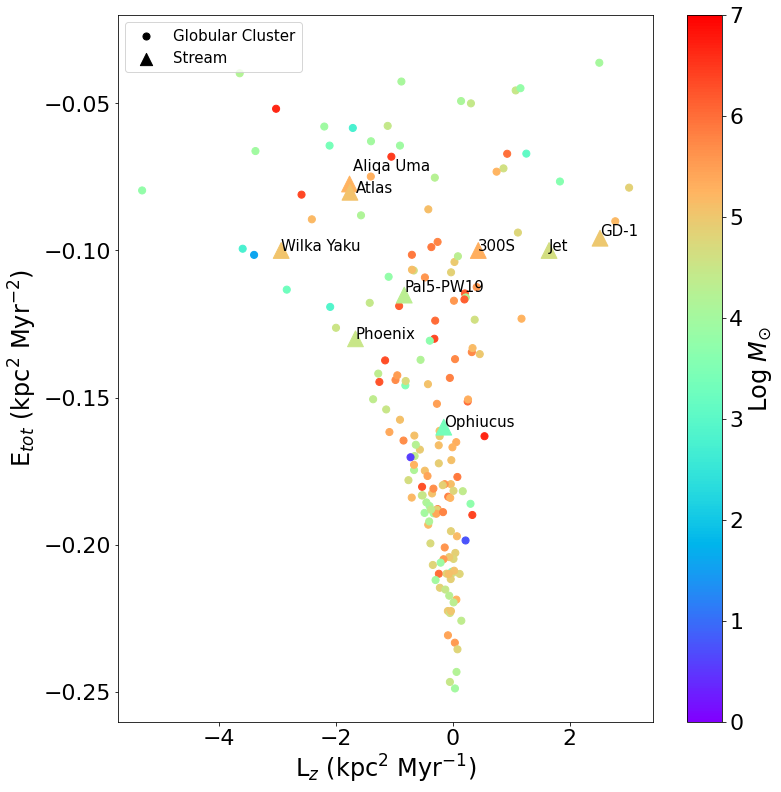

In [86]:
stream_mlogs = np.log10(stream_mass)
cmap = plt.cm.rainbow
norm = mpl.colors.Normalize(vmin=0,vmax=7)

fig = plt.figure(figsize=(12,13))
ax1 = plt.subplot()
ax2 = plt.subplot()
ax3 = plt.subplot()
ax4 = plt.subplot()
ax5 = plt.subplot()

img = ax1.scatter(lz,energies,c=mass_logs,s=50,norm=norm,cmap=cmap)
ax2.scatter(stream_momenta[0:4],stream_energy[0:4],c=stream_mlogs[0:4],cmap=cmap,norm=norm,marker='^',s=250)#,label=tracks)
ax3.scatter(ting_l[0:5],ting_e[0:5],c=ting_logmass[0:5],cmap=cmap,norm=norm,marker='^',s=250)#,label=ting_st)
ax4.scatter([],[],c="black",s=50,label="Globular Cluster")
ax5.scatter([],[],marker="^",c="black",s=150,label="Stream")
plt.ylim(-0.26,-0.02)
fig.colorbar(img,ax=ax1,label="Log $M_{\odot}$")
plt.xlabel("L$_z$ (kpc$^2$ Myr$^{-1}$)")
plt.ylabel("E$_{tot}$ (kpc$^2$ Myr$^{-2}$)")

tracks[0] = ''
tracks[3] = ''
tracks[2] = "GD-1"

for i, label in enumerate(tracks[0:4]):
    ax2.annotate(label,(stream_momenta[i],stream_energy[i]+.001),fontsize=15)
    
for i, label in enumerate(ting_st[0:5]):
    ax2.annotate(label,(ting_l[i],ting_e[i]),fontsize=15)
    
ax2.annotate("Aliqa Uma",(stream_momenta[0]*.97,stream_energy[0] + .0045),fontsize=15)
ax2.annotate("Atlas",(stream_momenta[3]+.1,stream_energy[3]),fontsize=15)
#ax2.axvline(palgc_lz)
#ax2.axhline(palgc_e)
plt.legend(fontsize=15)
plt.show()

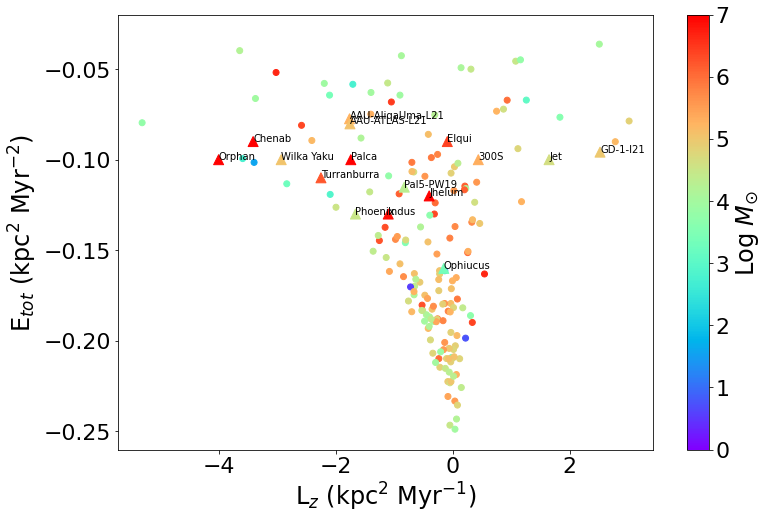

In [24]:
stream_mlogs = np.log10(stream_mass)
cmap = plt.cm.rainbow
norm = mpl.colors.Normalize(vmin=0,vmax=7)

fig = plt.figure(figsize=(12,8))
ax1 = plt.subplot()
ax2 = plt.subplot()
ax3 = plt.subplot()

img = ax1.scatter(lz,energies,c=mass_logs,norm=norm,cmap=cmap)
ax2.scatter(stream_momenta[0:4],stream_energy[0:4],c=stream_mlogs[0:4],cmap=cmap,norm=norm,marker='^',s=100)#,label=tracks)
ax3.scatter(ting_l,ting_e,c=ting_logmass,cmap=cmap,norm=norm,marker='^',s=100)#,label=ting_st)
plt.ylim(-0.26,-0.02)
fig.colorbar(img,ax=ax1,label="Log $M_{\odot}$")
plt.xlabel("L$_z$ (kpc$^2$ Myr$^{-1}$)")
plt.ylabel("E$_{tot}$ (kpc$^2$ Myr$^{-2}$)")

for i, label in enumerate(tracks[0:4]):
    ax2.annotate(label,(stream_momenta[i],stream_energy[i]),fontsize=10)
    
for i, label in enumerate(ting_st):
    ax2.annotate(label,(ting_l[i],ting_e[i]),fontsize=10)
#ax2.axvline(palgc_lz)
#ax2.axhline(palgc_e)
plt.show()

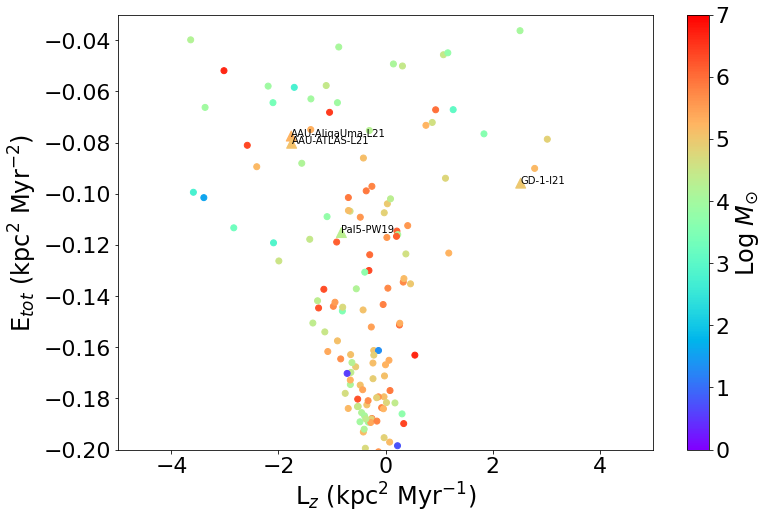

In [19]:
stream_mlogs = np.log10(stream_mass)
cmap = plt.cm.rainbow
norm = mpl.colors.Normalize(vmin=0,vmax=7)

fig = plt.figure(figsize=(12,8))
ax1 = plt.subplot()
ax2 = plt.subplot()

img = ax1.scatter(lz,energies,c=mass_logs,norm=norm,cmap=cmap)
ax2.scatter(stream_momenta[0:4],stream_energy[0:4],c=stream_mlogs[0:4],cmap=cmap,norm=norm,marker='^',s=100,label=tracks)
plt.ylim(-0.26,-0.02)
fig.colorbar(img,ax=ax1,label="Log $M_{\odot}$")
plt.xlabel("L$_z$ (kpc$^2$ Myr$^{-1}$)")
plt.ylabel("E$_{tot}$ (kpc$^2$ Myr$^{-2}$)")

for i, label in enumerate(tracks[0:4]):
  
    ax2.annotate(label,(stream_momenta[i],stream_energy[i]),fontsize=10)

plt.ylim(-0.2,-0.03)
plt.xlim(-5,5)
plt.show()

In [77]:
count = 0
for i in pericenters:
    if (np.isnan(i)):
        count += 1
print(count)
       

9


In [85]:
len(df.loc[df["pericenter"] < 10]["pericenter"])

140

In [8]:
#now transform to galactocentric coords (assuming default solar vel + pos - see link above)
gc1 = c1.transform_to(coord.Galactocentric)

In [17]:
print(gc1.x, gc1.y, gc1.z)
print(gc1.v_x, gc1.v_y, gc1.v_z)


7.1970585973536085 kpc 0.22364519881190617 kpc 15.725603167408744 kpc
-45.683760871576744 km / s -149.92448254498515 km / s -11.322419809788432 km / s


## Compute the orbit of the cluster :

We select Pal 5's progenitor orbit from above

In [11]:
glob_w0 = gd.PhaseSpacePosition(
    [gc1.x.value,  gc1.y.value,  gc1.z.value] * u.kpc ,
    [gc1.v_x.value,  gc1.v_y.value,  gc1.v_z.value]*u.km/u.s
)
prog_orbit = H.integrate_orbit(
    glob_w0, 
    dt=1, t1=0, t2=5*u.Gyr, 
    Integrator=gi.DOPRI853Integrator
).to_frame(test_frame)

print(prog_orbit.pericenter(), prog_orbit.apocenter())

7.18575800278673 kpc 16.238725217741308 kpc


Compare orbit plot to orbit in static (non-barred) potential:

orbit pericenter and apocenter
7.18575800278673 kpc 16.238725217741308 kpc


Text(0.5, 0.98, 'Orbit in Milky Way-like potential')

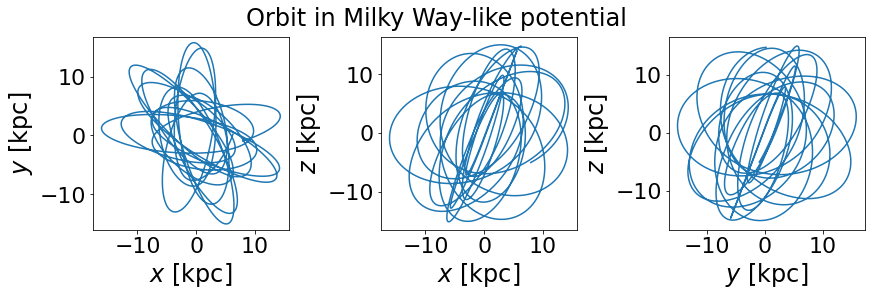

In [12]:
prog_orbit = H.integrate_orbit(
    glob_w0, 
    t=prog_orbit.t,
    Integrator=gi.DOPRI853Integrator
)
print('orbit pericenter and apocenter')
#here you can easily compute the orbital parameters such as apocenter/pericenter 
print(prog_orbit.pericenter(), prog_orbit.apocenter())
fig = prog_orbit.plot()
fig.suptitle('Orbit in Milky Way-like potential', fontsize=24)

In [19]:
np.median(prog_orbit.angular_momentum()[-1])

<Quantity -0.79631084 kpc2 / Myr>

## Compute a stream model 

Now setting up a cluster to run a stream model. You won't need this at first when you just check the pericenters and apocenters of streams vs globulars

In [20]:
glob_pot = gp.HernquistPotential( # we can use a Plummer here if we want
    m=5e4*u.Msun, #mass of your cluster)
    c=1*u.pc, #concentration of your hernquist cluster 
    units=galactic
)
df = gd.FardalStreamDF()
gen = gd.mockstream.MockStreamGenerator(
    gd.FardalStreamDF(random_state=np.random.default_rng(42)), 
    H, 
    glob_pot
)


In [21]:
opts = dict(
    release_every=1, # sets the amount of stars you release every time step 
    dt=-1 * u.Myr, #integration time step, here 1 Myr
    t1=0 * u.Gyr, # intitial time
    t2=-4 * u.Gyr, #amount of time you integrate for ( 4 Gyr)
    n_particles=1 #how many particles you release per time step. 
)

stream, prog = gen.run(
    glob_w0, 
    prog_mass=glob_pot.parameters['m'], 
    **opts
)


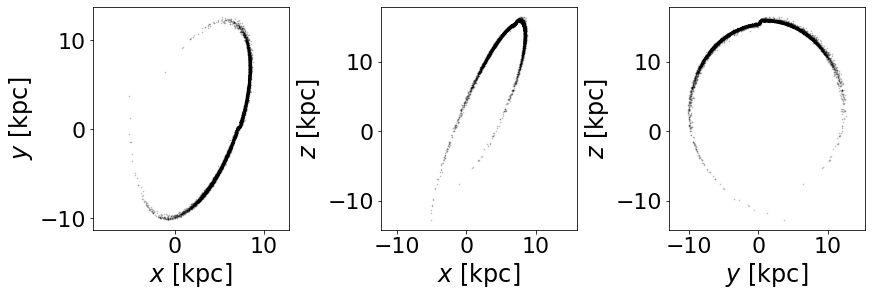

In [22]:
# Plot the stream
stream_style = dict(s=2, alpha=0.2, c='black')
_ = stream.plot(**stream_style)

Great this looks like Pal 5!

## Gaussians:

In [3]:
def r(theta,a,b,c,d,start,stop):
    return np.exp(a + b*theta + c*theta**2 + d*theta**3)

def get_spiral_arms(a,b,c,d,start,stop):
    angles = np.linspace(np.radians(start),np.radians(stop),100)

    r_vals = r(angles,a,b,c,d,start,stop)
    xvals = r_vals*np.cos(angles)
    yvals = r_vals*np.sin(angles)
    
    
    sigma = .25
    mu = 0.01
    
    noise = sigma*np.random.randn(len(xvals)) + mu

    return xvals,yvals, (xvals + noise), (yvals + noise)


x1, y1, x1noise, y1noise = get_spiral_arms(1.1923, 0.1499, -0.007056, 0.0, 40, 250)
x2, y2, x2noise, y2noise = get_spiral_arms(7.4144, -2.4119, 0.3105, -0.01223, 275, 620)
x3, y3, _ ,_  = get_spiral_arms(6.8191, -2.1630, 0.2888, -0.01163, 275, 570)
x4, y4,_,_ = get_spiral_arms(2.6019, -0.3315, 0.03829, 0.0, 275, 500)
x5, y5,_,_ = get_spiral_arms(1.7840, -0.04095, 0.01956, 0.0, 280, 475)
x6, y6,_,_ = get_spiral_arms(3.1816, -0.5408, 0.07024, 0.0, 280, 355)

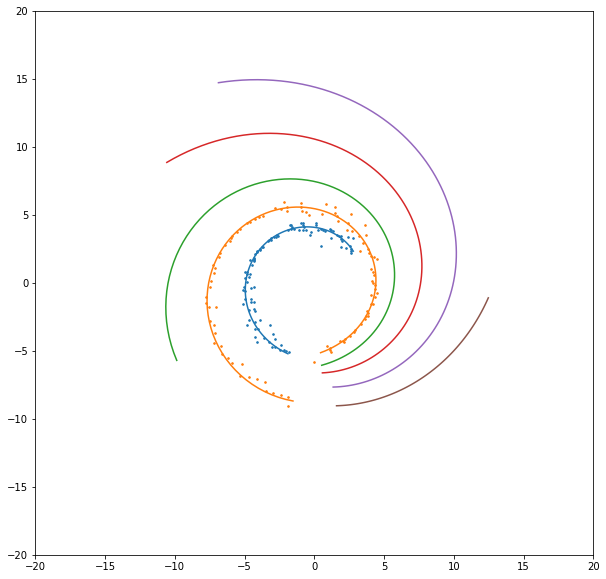

In [4]:
plt.figure(figsize=(10,10))
plt.plot(x1,y1)
plt.scatter(x1noise,y1noise,s=10,marker='.')
plt.plot(x2,y2)
plt.scatter(x2noise,y2noise,s=10,marker='.')
plt.plot(x3,y3)
plt.plot(x4,y4)
plt.plot(x5,y5)
plt.plot(x6,y6)
plt.xlim(-20,20)
plt.ylim(-20,20)
plt.show()

## Add rotation curve to GMC:

In [6]:
(2518.7**2 + 10900.4**2)**0.5

11187.60786987102

In [39]:
xyz = np.zeros((3, 20000))
xyz[0] = np.linspace(0, 25, xyz.shape[1])
for pot in [mw]:
    vcirc = pot.circular_velocity(xyz)

In [45]:
x = -2518.7
y = -10900.4
v = vcirc[11188].value

theta = np.arctan2(y,x)
v_x = -v*np.sin(theta)
v_y = v*np.cos(theta)

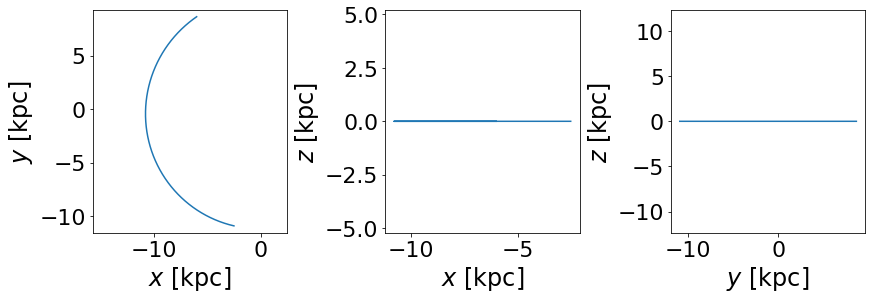

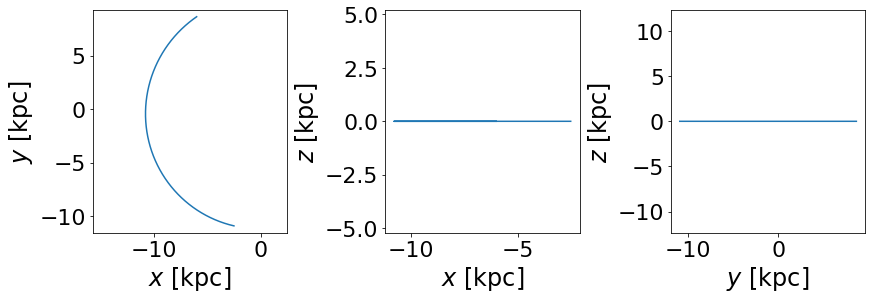

In [46]:
w0 = gd.PhaseSpacePosition(pos=[x,y,0]*u.pc,vel = [v_x,v_y,0]*u.km/u.s)
orbit = mw.integrate_orbit(w0, dt=-0.0001*u.Myr, t1=115.4798*u.Myr, t2=0*u.Myr)
orbit.plot(['x','y','z'])

In [69]:
orbit.t[-1]

<Quantity 0. Myr>

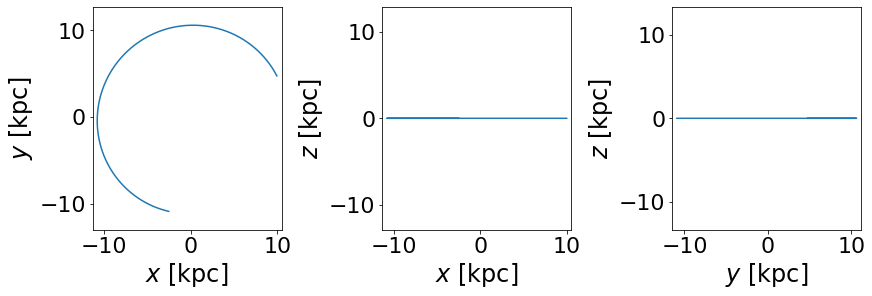

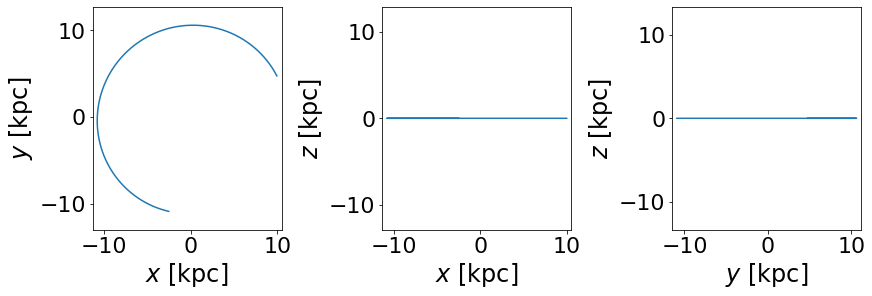

In [22]:
x0 = orbit.x[-1].value
y0 = orbit.y[-1].value
z0 = orbit.z[-1].value

v_x0 = orbit.v_x[-1].value
v_y0 = orbit.v_y[-1].value
v_z0 = orbit.v_z[-1].value


w00 = gd.PhaseSpacePosition(pos=[x0,y0,z0]*u.kpc,vel = [v_x0,v_y0,v_z0]*u.kpc/u.Myr)
orbit = mw.integrate_orbit(w00, dt=0.0001*u.Myr, t1=0*u.Myr, t2=200*u.Myr)
orbit.plot(['x','y','z'])

In [34]:
orbit.v_z[1154798].to(u.pc/u.Myr)

<Quantity 0. pc / Myr>

In [38]:
orbit.t[1154798]

<Quantity 115.4798 Myr>

In [36]:
orbit.x[-1].to(u.pc)

<Quantity -2518.72053461 pc>

In [37]:
orbit.y[-1].to(u.pc)

<Quantity -10900.39525515 pc>

In [4]:
densities = np.array([30,100,300,1000])
masses = np.array([0.32e5,0.64e5,1.28e5,2e5])


((3*masses)/(8*np.pi*densities))**(1/3)

array([5.03079599, 4.24313767, 3.70672218, 2.87941191])

In [3]:
df = pd.read_fwf("/Users/colinholmhansen/desktop/table.txt",header=None)
df.columns = ["Index","Name","Mass","Rh"]

In [4]:
df

,Index,Name,Mass,Rh
0,1,2MASS-GC01,35100,4.70
1,2,2MASS-GC02,15800,2.85
2,3,AM1,19200,19.86
3,4,AM4,756,15.00
4,5,Arp2,37000,18.45
...,...,...,...,...
154,55,Ter9,120000,1.90
155,56,Ton2,69100,4.60
156,57,UKS1,77000,3.84
157,58,VVV-CL001,135000,2.94


In [5]:
mass = df["Mass"]
rh = df["Rh"]

In [6]:
np.median(np.array(mass))

125000.0

In [7]:
125_000/0.6

208333.33333333334

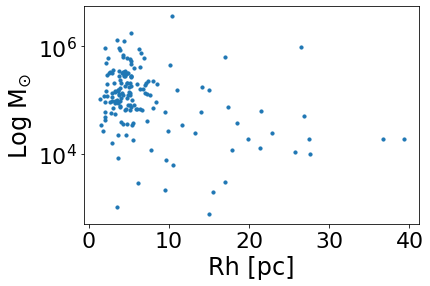

In [29]:
plt.scatter(rh, mass,s=10)
plt.yscale('log')
plt.xlabel("Rh [pc]")
plt.ylabel("Log M$_{\odot}$")
plt.show()

(0.0, 10.0)

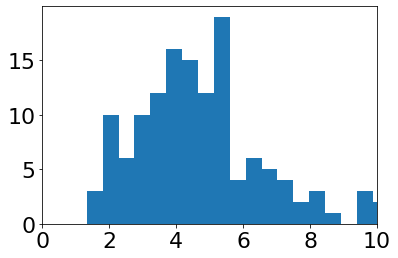

In [38]:
plt.hist(rh,bins=80)
plt.xlim((0,10))